## Cuidado! Lluvia de Hamburguesas: 
## Análisis con SVM (Support Vector Machines)


## Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

## Configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import crear_archivo_predicciones
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from preprocessing import manejo_missing_values
from preprocessing import aplicarOneHot
from preprocessing import aplicarPCA
from preprocessing import normalizar_entre_0_y_1
from preprocessing import normalizar_segun_maximo_valor_absoluto

Primero cargamos los datos y hacemos la división del dataset quedándonos con un 10% de los datos para el hold out:

In [2]:
x,y = obtener_training_set()
x_val,y_val = obtener_valdev_set()

## Support Vectors Machine

Seguimos con este modelo que consiste en hallar un hiperplano que separe el espacio en 2 clases. Si el problema no es linealmente separable se utilizan kernels que son generalizaciones del producto interno que nos permiten operar de manera implicita con nuevos atributos. Devido a como está matematicamente planteado el algoritmo converge y no hay optimos locales.

Los hiperparametros a buscar son:

* C: Suavidad del margen. Si C tiende a 0 decimos que es soft, permite demasiados miss-clasifications. Si tiende a infinito decimos que es hard, pidiendo que los puntos sean perfectamente separables.
* Tipo de kernel: Puede ser polinomial, radial, sigmoideo, entre otros.

## Preprocesamiento

### One Hot Encoding
En primer lugar aplicamos One-hot encoding para las variables categóricas:

In [3]:
x = aplicarOneHot(x)
x_val = aplicarOneHot(x_val)

### Reducción de dimensionalidad
Como en el caso de KNN creemos que es buena idea obtener las componentes principales que expliquen una cantidad alta de varianza.


El numero minimo de componentes para explicar el 95% de la varianza es: 7


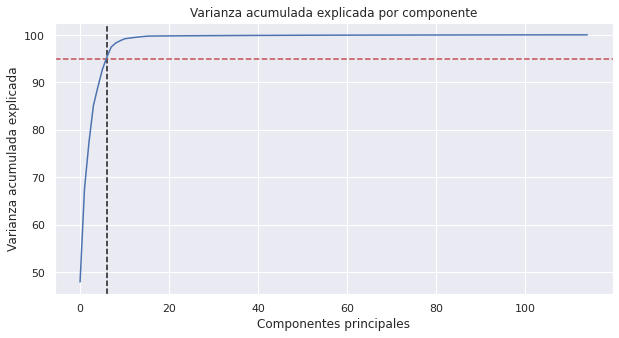

In [4]:
pca, componentes_principales = aplicarPCA(x,x)

var_acumulada = np.cumsum(pca.explained_variance_ratio_) * 100

k = np.argmax(var_acumulada > 95)
print("El numero minimo de componentes para explicar el 95% de la varianza es: " + str(k+1))

plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_acumulada)

Vemos que para 7 componentes ya alcanzamos una varianza mayor al 95%.

In [5]:
pca, componentes_principales = aplicarPCA(x.copy(), x.copy(), 7)

### Normalización

Una vez aplicada la reducción de dimensionalidad emplearemos 2 preprocesamientos distintos, en el primero procedemos a normalizar nuestros datos de manera tal que los valores posibles para cada uno de los features esté entre 0 y 1. Para ello usamos el MixMaxScaler. En el otro caso utilizaremos MaxAbsScaler, el cual escala cada feature segun su máximo valor absoluto.

In [6]:
x_normalizado_uno = normalizar_entre_0_y_1(componentes_principales.copy(), componentes_principales.copy())
x_normalizado_dos = normalizar_segun_maximo_valor_absoluto(componentes_principales.copy(), componentes_principales.copy())

## Selección de Hiperparámetros

* Para seleccionar los mejores hiperparámetros vamos a usar Cross Validation con 3 folds estratificados. La evaluación se realizará usando como metrica el AUC ROC
* Los valores del parametro C que utilizaremos para el grid search son: 1,10,50,100 y 120.
* Para el kernell probaremos con polinomial, lineal y sigmoideo.

Veamos con cual preprocesamiento obtenemos mejores resultados durante el entrenamiento con folds.

In [18]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=119)
    
svm_clasificador_uno = SVC(probability=False)
svm_clasificador_uno = GridSearchCV(svm_clasificador_uno, {'C':[1,10,50,100,120],'kernel':['poly','rbf','linear']}, n_jobs = -1, cv = kf, scoring ='roc_auc')
svm_clasificador_uno.fit(x_normalizado_uno, y.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=119, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 120],
                         'kernel': ['poly', 'rbf', 'linear']},
             scoring='roc_auc')

In [19]:
resultados = pd.DataFrame(svm_clasificador_uno.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_C','param_kernel','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_C,param_kernel,mean_test_score,mean_score_time
11,1,100,linear,0.845328,6.549974
8,2,50,linear,0.845327,6.421576
14,3,120,linear,0.845326,6.199520
5,4,10,linear,0.845320,6.449873
2,5,1,linear,0.845276,6.587923


In [7]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=119)
    
svm_clasificador_dos = SVC(probability=False)
svm_clasificador_dos = GridSearchCV(svm_clasificador_dos, {'C':[1,10,50,100,120],'kernel':['poly','rbf','linear']}, n_jobs = -1, cv = kf, scoring ='roc_auc')
svm_clasificador_dos.fit(x_normalizado_dos, y.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=119, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 120],
                         'kernel': ['poly', 'rbf', 'linear']},
             scoring='roc_auc')

In [8]:
resultados = pd.DataFrame(svm_clasificador_dos.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_C','param_kernel','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_C,param_kernel,mean_test_score,mean_score_time
8,1,50,linear,0.845327,6.291406
11,2,100,linear,0.845327,6.209649
14,3,120,linear,0.845326,6.226714
5,4,10,linear,0.845316,6.634197
2,5,1,linear,0.845268,5.494160


Vemos que los resultados son muy similares. Por ello nos quedaremos con el primer preprocesamiento ya que en el entrenamiento sobre un fold logra obtener un auc score decimalmente superior.

## Entrenamiento y evaluación del modelo

In [20]:
svm_clasificador_uno.best_params_

{'C': 100, 'kernel': 'linear'}

In [7]:
svm_clasificador = SVC(C=100, kernel='linear', probability=True)
svm_clasificador.fit(x_normalizado_uno, y.values.ravel())

SVC(C=100, kernel='linear', probability=True)

### Matriz de confusión



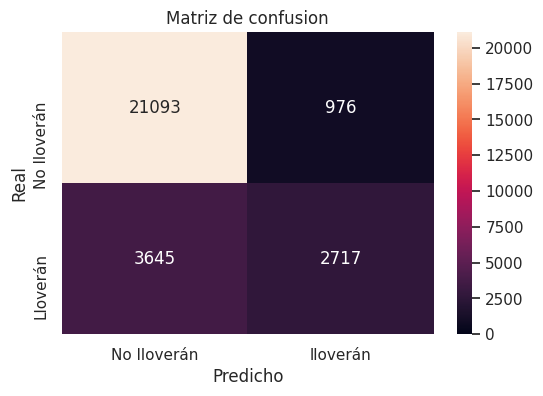

In [8]:
pca_val, componentes_principales_val = aplicarPCA(x, x_val, 7)
x_val_normalizado = normalizar_entre_0_y_1(componentes_principales.copy(), componentes_principales_val)
predicciones = svm_clasificador.predict(x_val_normalizado)
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [9]:
accuracy_score_got = accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy_score_got)

ACCURACY SCORE:  0.8374661461081214


#### Precision y Recall 



In [10]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.73571621987544 
RECALL:  0.427066960075448


#### F1 Score

In [11]:
f1_score_got = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1_score_got)

F1 SCORE:  0.5404276479363501


A pesar de tener una cantidad considerable de false positives, la diagonal principal de la matriz tiene una cantidad predominante con respecto a la otra diagonal por lo que es bastante respetable.
* Del total de dias que lloverán en el dataset(6362), logró prededir a 2717 de ellos(menos de la mitad).
* Del total de dias que no lloverán en el dataset(22069), logró prededir a 21093 de ellos(mucho mas de la mitad)
* Del total de predichos como que lloverán (3693), en 2717 de ellos realmente iba a llover al dia siguiente.

### Curva ROC

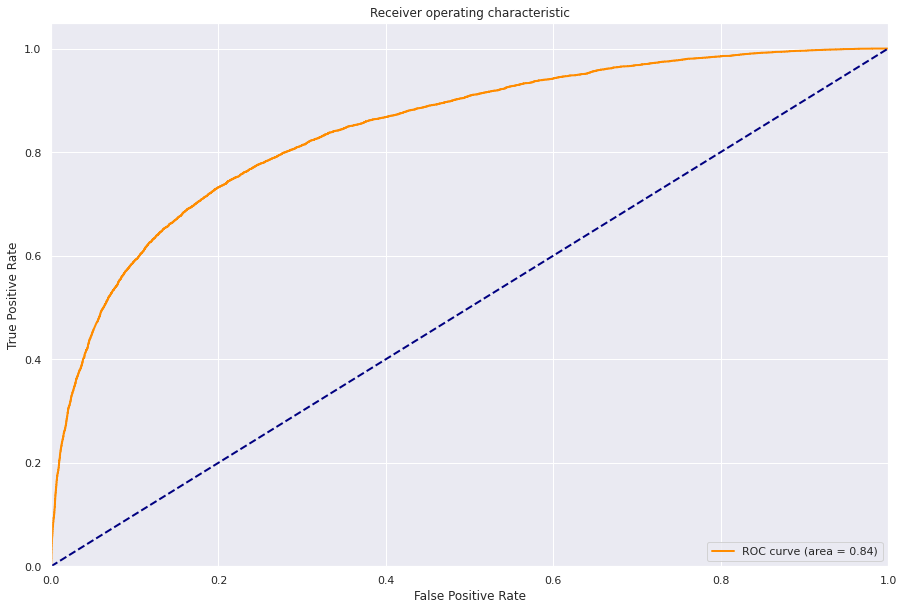

0.8444279721759178

In [12]:
predicciones_proba = svm_clasificador.predict_proba(x_val_normalizado)
fpr, tpr, thresholds = roc_curve(y_val, predicciones_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_val, predicciones_proba[:, 1]))

No está mal pero obtuvimos un AUC score mejor con un modelo mucho más simple(el árbol).

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento de transformar todas las variables a numericas.

In [13]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])

nuevo_ds = aplicarOneHot(nuevo_ds)
nuevo_ds.drop('id', inplace=True, axis=1)
pca_nds, componentes_principales_nds = aplicarPCA(x, nuevo_ds, 7)
nuevo_ds_normalizado = normalizar_entre_0_y_1(componentes_principales.copy(), componentes_principales_nds)

predicciones = svm_clasificador.predict(nuevo_ds_normalizado)
crear_archivo_predicciones(predicciones,"Support Vector Machines",ids_registro)